# AIS Summer Comp (Advay Vyas)

### Imports and data

In [552]:
# imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import pprint
import matplotlib.pyplot as plt
from math import sqrt

In [553]:
# load data
train_file_path = 'C:\\Users\\advay\\OneDrive\\Desktop\\Coding\\VSCode\\Python\\AIS Summer Comp 2022\\train.csv'
all_data = pd.read_csv(train_file_path)
all_data.head()

,ID,Population,Median Age,Unemployment Rate,Median Income,Poverty Rate,Median House Price
0,CA42,840562,35.6,5.1,7.8,26.5,455800
1,TX3,913161,37.5,4.0,6.2,54.5,365700
2,CA22,768917,33.0,6.6,15.2,24.5,298300
3,IL6,710626,42.1,3.1,4.6,53.2,334200
4,IN5,791257,38.3,3.5,8.1,47.9,219100


In [554]:
# get target
y = all_data['Median House Price']
y.head()

0    455800
1    365700
2    298300
3    334200
4    219100
Name: Median House Price, dtype: int64

In [555]:
# creating X
features = ['Unemployment Rate', 'Median Income', 'Poverty Rate']
X = all_data[features]
X.head()

,Unemployment Rate,Median Income,Poverty Rate
0,5.1,7.8,26.5
1,4.0,6.2,54.5
2,6.6,15.2,24.5
3,3.1,4.6,53.2
4,3.5,8.1,47.9


### Feature Engineering

#### Importance

In [556]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=True, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

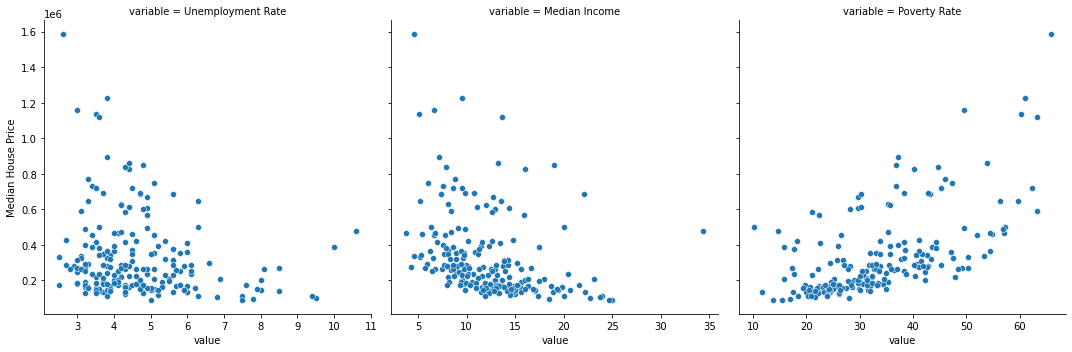

In [557]:
# seaborn plotting
discrete_features = X.dtypes == int

sns.relplot(
    x="value", y="Median House Price", col="variable", data=all_data.melt(id_vars="Median House Price", 
        value_vars=features), facet_kws=dict(sharex=False),
);

### Refined RandomForestRegressor

#### Data distribution

In [558]:
# set up data distrubtion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 42)

In [559]:
# scaling train test split
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Evaluating the results

In [560]:
# evaluating function
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    error = sqrt(mean_squared_error(y_test, predictions))
    print(error)

    return error

In [561]:
# evaluating model
model = RandomForestRegressor(random_state = 42, criterion = 'squared_error', max_features = None)
model.fit(X_train, y_train)
print('RMSE (lower is better)')
base_accuracy = evaluate(model, X_test, y_test)

RMSE (lower is better)
155845.4314722764


### Predicting competition data

In [562]:
# reading competition data
competition_data_path = 'C:\\Users\\advay\\OneDrive\\Desktop\\Coding\\VSCode\\Python\\AIS Summer Comp 2022\\evaluation_input.csv'
competition_data = pd.read_csv(competition_data_path)
competition_data.head()

,ID,Population,Median Age,Unemployment Rate,Median Income,Poverty Rate
0,TX35,857654,33.0,4.1,18.4,25.2
1,PR16,678333,43.0,4.6,13.5,28.3
2,NY4,730314,40.4,3.6,5.7,43.6
3,OR1,858875,38.0,3.8,8.9,40.7
4,GA8,706237,37.6,5.3,17.3,22.7


In [563]:
# creating competition X
competition_X = competition_data[features]
competition_X.head()

,Unemployment Rate,Median Income,Poverty Rate
0,4.1,18.4,25.2
1,4.6,13.5,28.3
2,3.6,5.7,43.6
3,3.8,8.9,40.7
4,5.3,17.3,22.7


In [564]:
# scaling and fitting
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
competition_X_scaled = scaler.transform(competition_X)
pprint.pprint(competition_X_scaled)
model.fit(X, y)

array([[-3.81399923e-01,  1.33522784e+00, -7.16562917e-01],
       [-3.37245146e-02,  2.80817458e-01, -4.44038681e-01],
       [-7.29075332e-01, -1.39763172e+00,  9.01000286e-01],
       [-5.90005168e-01, -7.09037183e-01,  6.46058260e-01],
       [ 4.53021057e-01,  1.09852347e+00, -9.36340526e-01],
       [-5.90005168e-01, -3.64739917e-01, -5.14367516e-01],
       [-1.28535599e+00, -2.57147021e-01, -6.98980708e-01],
       [-1.14628582e+00, -7.09037183e-01,  6.28476051e-01],
       [ 4.53021057e-01, -1.71072704e-01,  2.41667459e-01],
       [ 8.70231548e-01,  8.83337674e-01, -1.15611813e+00],
       [ 3.58105671e-02,  1.03396773e+00,  1.20868894e+00],
       [-5.20470087e-01, -9.24222975e-01,  3.03205190e-01],
       [ 7.31161384e-01, -1.06516967e-01,  6.37267155e-01],
       [-3.11864841e-01, -8.81185816e-01,  7.07595990e-01],
       [-3.81399923e-01,  1.51705983e-01, -8.39638378e-01],
       [ 1.00930171e+00,  2.21748958e+00, -1.23523807e+00],
       [ 4.53021057e-01,  4.09928933e-01

RandomForestRegressor(max_features=None, random_state=42)

In [565]:
# competition predictions
competition_preds = model.predict(competition_X)
print(competition_preds)

[ 162670.  249735.  397814.  339023.  180517.  208965.  178591.  290133.
  393249.  170696.  725730.  624062.  304861.  330039.  175151.  167455.
  357107.  222639.  212135.  228294.  206829.  157750.  233098.  551298.
  400018.  814191.  509442.  396206.  458149.  272494.  204233.  459375.
  265476.  162962.  244657.  201994.  165387.  457906.  234622.  211976.
  215872.  220383.  217367.  464476.  271275.  604595.  293768.  337581.
  184743.  182519.  189915. 1076685.  216454.  178373.  241120.  194431.
  312966.  187486.  148414.  238447.  386288.  411228.  454096.  255346.
  182750.  370478.  227383.  388339.  720687.  347452.  226774.  232351.
  278397.  156725.  304692.  237573.  314624.  251790.  229938.  361797.
  180613.  221526.  262328.  552265.  716637.  282611.  341755.  378660.
  214254.  353278.  168556.  583296.  505893.  410366.  280412.  160744.
  583189.  155484.  278993.  296321.  314470.  492117.  139389.  220723.
  201431.  260622.  363523.  178540.  214089.  1995

### Generating submission

In [566]:
# Creating and outputting DataFrame
output = pd.DataFrame({'ID': competition_data.ID, 'Median House Price': competition_preds})
output.to_csv('Vyas_Advay_answer.csv', index=False)